In [96]:
import numpy as np
from qutip import tensor, basis, ket2dm
from qutip_qip.circuit import QubitCircuit
from chalmers_qubit.sarimner import (
    SarimnerProcessor, SarimnerModel, SarimnerCompiler, DecoherenceNoise
)
from chalmers_qubit.base.operations import project_on_qubit

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Single Qubit Gate Example
We begin by creating a quantum circuit that has two qubits, and we independently perform two single-qubit gates on them

In [124]:
num_qubits = 1
circuit = QubitCircuit(num_qubits)

#circuit.add_gate("RX", targets=0, arg_value=np.pi/2)
#circuit.add_gate("RY", targets=0, arg_value=np.pi/2)
circuit.add_gate("X", targets=0)
circuit.add_gate("GLOBALPHASE", targets=0, arg_value=np.pi / 2)

Next we define the hardware parameters that we will use when simulating this quantum circtuit. We therefore define:
- `qubit_frequencies`: List of the qubit frequency of each qubit defined in GHz.
- `anharmonicities`: List of the qubit anharmonicitues of each qubit defined in GHz.
- `t1`: List with relaxation times $T_1$ for each qubit in nano seconds.
- `t2`: List with pure dephasing times $T_2$ for each qubit in nano seconds.

In [150]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3]
# T1's and T2's for the qubits in (ns)
t1 = [60*1e3]
t2 = [100*1e3]

Next we take these hardware parameters that we have defined and we load them onto our superconducting hardware model `SarimnerModel`. This along with the `compiler` and `noise` is given to `SarimnerProcessor`.

In [151]:
# Load the physical parameters onto the model
model = SarimnerModel(qubit_frequencies=qubit_frequencies, 
                      anharmonicities=anharmonicities)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Add noise
noise = [DecoherenceNoise(t1=t1, t2=t2)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=noise)

Once we have defined our processor we can load the quantum circuit onto the processor. This will compile the circuit into a pulse sequence.

In [152]:
tlist, coeffs = sarimner.load_circuit(circuit)

We can choose to plot the pulse sequence

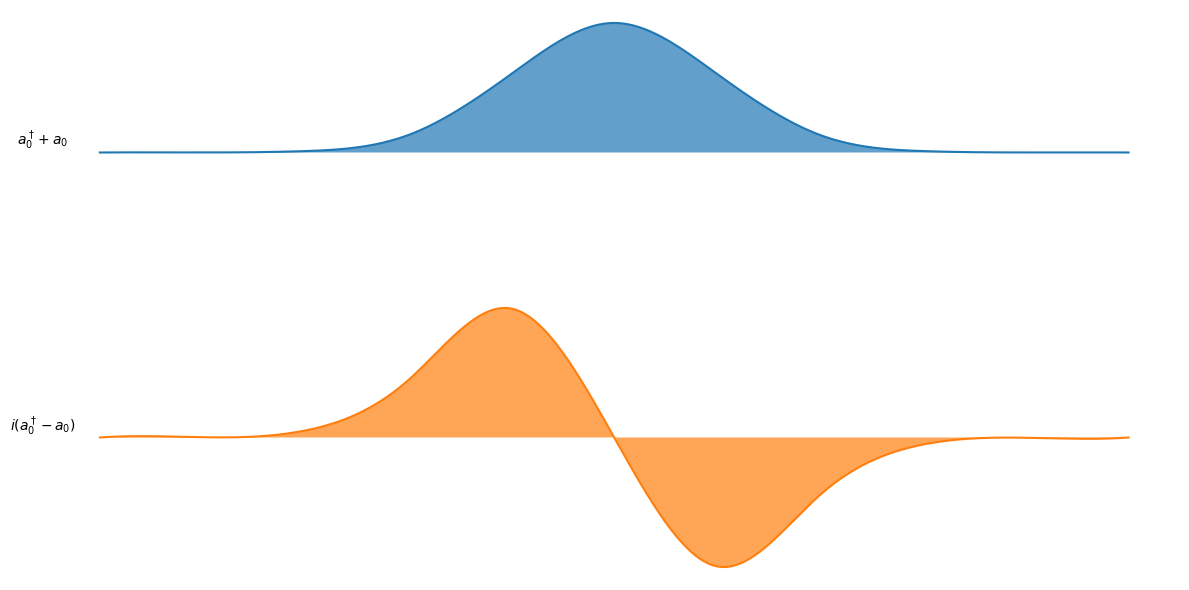

In [153]:
sarimner.plot_pulses();

Now we can exectue this pulse sequence on the processor by using `run_state` with a given `initial state`

In [154]:
initial_state = basis(3,0)
result = sarimner.run_state(initial_state)
final_state = result.states[-1]
final_state

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.92394652e-04-3.28874787e-18j  3.28475501e-04+1.40913945e-03j
  -7.45884548e-08-5.64222937e-07j]
 [ 3.28475501e-04-1.40913945e-03j  9.99607416e-01+5.30977480e-18j
   5.88896585e-05-2.26465954e-04j]
 [-7.45884548e-08+5.64222937e-07j  5.88896585e-05+2.26465954e-04j
   1.89575093e-07-1.78328455e-18j]]

Since we simulated the system for a three-level system we have to project it onto the computational subspace using the function `project_on_qubit`

In [155]:
project_on_qubit(final_state)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[3.92394652e-04-3.28874787e-18j 3.28475501e-04+1.40913945e-03j]
 [3.28475501e-04-1.40913945e-03j 9.99607416e-01+5.30977480e-18j]]

# Two Qubit Gate Example

Next we show a simple circuit using a two-qubit `CZ`-gate and how to compile it onto our processor.

In [37]:
# Define a circuit and run the simulation
num_qubits = 2
circuit = QubitCircuit(num_qubits)
circuit.add_gate("CZ", controls=0, targets=1)

Just as before we start by defining our hardware parameters. Additionally we need to supply a coupling paremeter.

- `cpl_matrix`: Coupling matrix where the element $(i,j)$ defines the coupling strength between qubit $i$ and qubit $j$ in GHz.

In [38]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0, 2 * np.pi * 5.4]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3, - 2 * np.pi * 0.3]
# T1's and T2's for the qubits in (ns)
t1 = [60 * 1e3, 80 * 1e3]
t2 = [100 * 1e3, 105 * 1e3]

# Times in (ns)
t = 100
# corresponding coupling
g = np.sqrt(2) * np.pi / t
# Coupling matrix
coupling_matrix = np.array([[0, g],
                       [0, 0]])

and load them onto our model

In [39]:
# Load the physical parameters onto the model
model = SarimnerModel(
    qubit_frequencies=qubit_frequencies,
    anharmonicities=anharmonicities,
    coupling_matrix=coupling_matrix,
)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler)

then we can compile the circuit onto our processor

In [40]:
tlist, coeffs = sarimner.load_circuit(circuit)

and plot the pulses

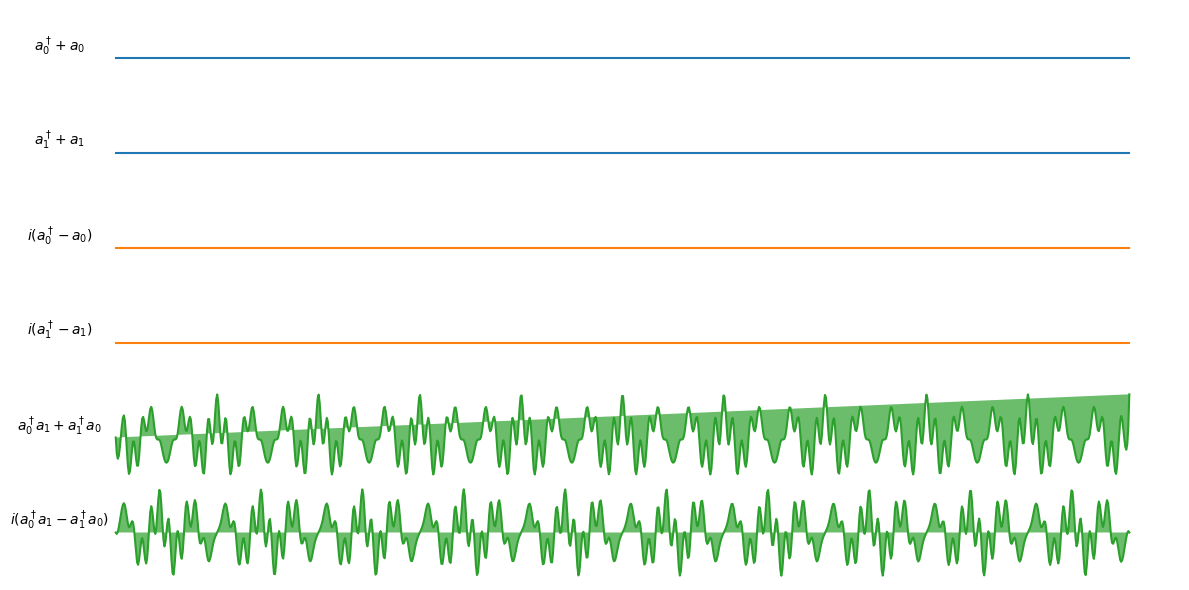

In [41]:
sarimner.plot_pulses();

To see that the CZ-gate is implemented correctly we will now simulate the circuit using the master equation simulation and look at the expectation values of the $|11\rangle$ and $|20\rangle$ states.

In [42]:
ket11 = tensor(basis(3,1),basis(3,1))
ket20 = tensor(basis(3,2),basis(3,0))
# List of operators we wanna compute the expectation value for during the simulation
e_ops = [ket2dm(ket11), ket2dm(ket20)]
result = sarimner.run_state(ket11, e_ops=e_ops, options={'nsteps': 1e5, 'store_final_state': True})

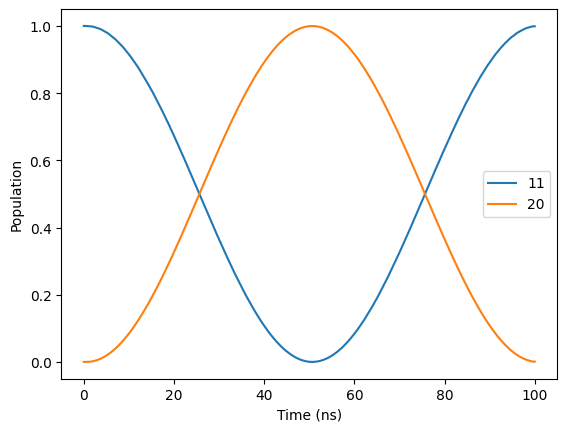

In [43]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0],label='11')
plt.plot(result.times,result.expect[1],label='20')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.legend()

And if we print the final state we see that the $|11\rangle$ state has the desired $-1$ phase.

In [44]:
qubit_state = project_on_qubit(result.final_state)
qubit_state

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.99939892+0.01027983j]]

## Three Qubit Gate Example

Finally we will demonstrate the implementation of the three-qubit gate.

Since this gate is not part of qutip `QubitCircuit` we have to defined the gate ourself and supply as `user_gates`

In [163]:
from qutip import Qobj
# Ideal gate
def cczs(args):
    theta, phi, gamma = args
    U = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, -np.exp(-1j*gamma)*np.sin(theta/2)**2 + np.cos(theta/2)**2, 
                                    (1/2)*(1 + np.exp(-1j*gamma))*np.exp(-1j*phi)*np.sin(theta), 0],
                  [0, 0, 0, 0, 0, (1/2)*(1 + np.exp(-1j*gamma))*np.exp(1j*phi)*np.sin(theta), 
                                    -np.exp(-1j*gamma)*np.cos(theta/2)**2 + np.sin(theta/2)**2, 0],
                  [0, 0, 0, 0, 0, 0, 0, -np.exp(1j*gamma)]], dtype="complex")
    return Qobj(U, dims=[[2]*3, [2]*3])

In [164]:
# Define a circuit and run the simulation
num_qubits = 3

circuit = QubitCircuit(num_qubits)
circuit.user_gates = {"CCZS": cczs}
circuit.add_gate("CCZS", targets=[0,1,2], arg_value=[np.pi/2,0,0])

In [182]:
# Qubit frequencies in (GHz)
qubit_frequencies = [2 * np.pi * 5.0, 2 * np.pi * 5.4, 2 * np.pi * 5.2]
# Anharmonicity in (GHz)
anharmonicities = [- 2 * np.pi * 0.3, - 2 * np.pi * 0.3, - 2 * np.pi * 0.3]
# T1's and T2's for the qubits in (ns)
t1 = [60] * num_qubits
t2 = [100] * num_qubits
# Times in (ns)
t = 150
# corresponding coupling
g = np.sqrt(2) * np.pi / t
print(g)
# Coupling matrix in (GHz)
coupling_matrix = np.array([[0, g, g], [0, 0, 0], [0, 0, 0]])

0.029619219587722442


In [183]:
# Load the physical parameters onto the model
model = SarimnerModel(
    qubit_frequencies=qubit_frequencies,
    anharmonicities=anharmonicities,
    coupling_matrix=coupling_matrix,
)

# Choose compiler
compiler = SarimnerCompiler(model=model)

# Add noise
noise = [DecoherenceNoise(t1=t1, t2=t2)]

# Create the processor with the given hardware parameters
sarimner = SarimnerProcessor(model=model, compiler=compiler, noise=[])

In [184]:
tlist, coeffs = sarimner.load_circuit(circuit)

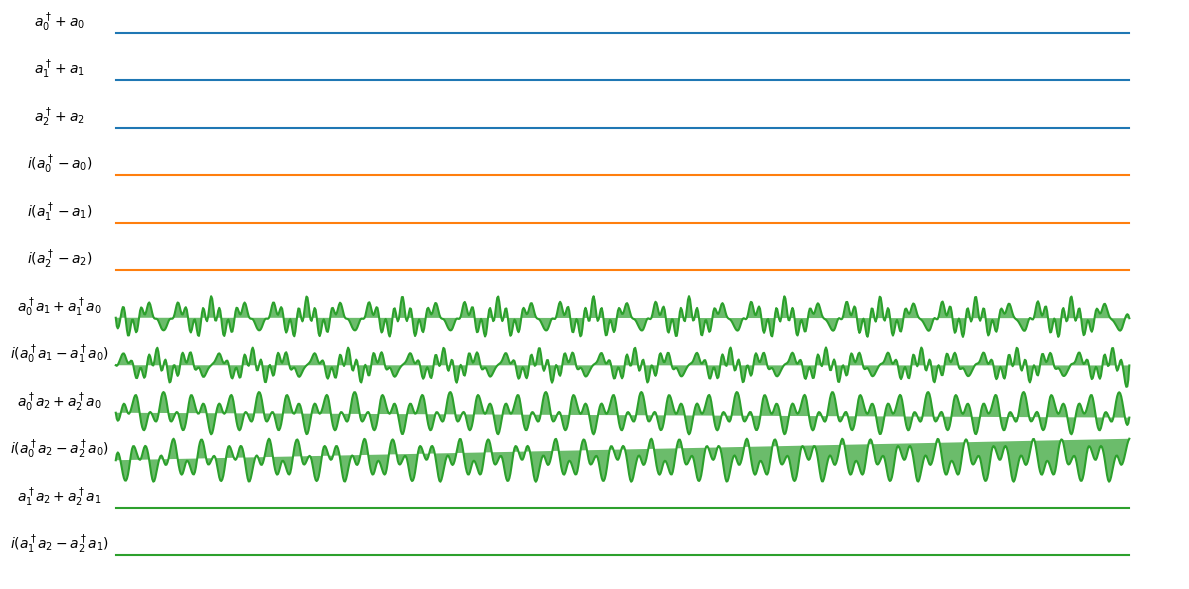

In [185]:
sarimner.plot_pulses();

In [186]:
ket110 = tensor([basis(3,1),basis(3,1),basis(3,0)])
ket101 = tensor([basis(3,1),basis(3,0),basis(3,1)])
ket200 = tensor([basis(3,2),basis(3,0),basis(3,0)])
e_ops = [ket2dm(ket110), ket2dm(ket101), ket2dm(ket200)]
result = sarimner.run_state(ket110, e_ops=e_ops, options={'store_states':True, 'nsteps':1e5, 'atol': 1e-12})

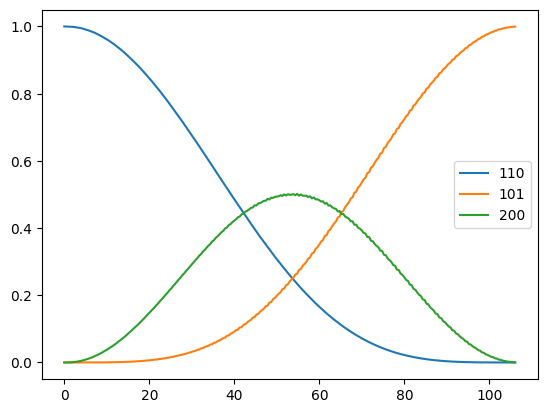

In [187]:
import matplotlib.pyplot as plt
plt.plot(result.times,result.expect[0], label="110")
plt.plot(result.times,result.expect[1], label="101")
plt.plot(result.times,result.expect[2], label="200")
plt.legend()

In [188]:
prop = sarimner.run_propagator(options={"nsteps":1e5})
project_on_qubit(prop)

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          9.99868852e-01+0.00743627j
   2.17588686e-04-0.01232597j  0.00000000e+00+0.j
   7.66585409e-04-0.00737583j  0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.25861168e-04-0.01234443j
   9.99748421e-01+0.01178165j  0.00000000e+00+0.j
   9.72895543e-04+0.01452093j  0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          9.99685827e-01+0.01898625j
   0.00000000e+00+0.j         -9.88769718e-03+0.00596847j
   1.15178605e-02+0.00120332j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j 

In [92]:
cczs((np.pi/2,0,0))

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.22044605e-16  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.000000